<a href="https://colab.research.google.com/github/0ginny/TIL/blob/main/240424_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Masterclass - Style Transfer

- Based on https://www.tensorflow.org/tutorials/generative/style_transfer?hl=en
- Style transfer paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

화풍을 바꾸는 거지.

## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.15.0'

## Loading the pre-trained convolutional neural network (VGG19)


In [ ]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
len(network.layers)

22

## Loading and pre-processing the images

### Content image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Vision_AZ

/content/drive/MyDrive/Colab Notebooks/Vision_AZ


In [ ]:
content_image = tf.keras.preprocessing.image.load_img('./Images/chaves.jpeg')

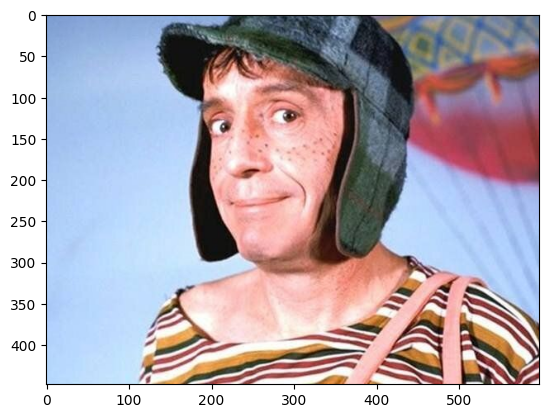

In [ ]:
plt.imshow(content_image)

In [ ]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [ ]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (448, 598, 3), 0.0, 255.0)

In [ ]:
content_image = content_image / 255

In [ ]:
content_image.min(), content_image.max()

(0.0, 1.0)

In [ ]:
content_image = content_image[tf.newaxis, :]

In [ ]:
content_image.shape

(1, 448, 598, 3)

### Style image

In [ ]:
style_image = tf.keras.preprocessing.image.load_img('./Images/tarsila_amaral.jpg')

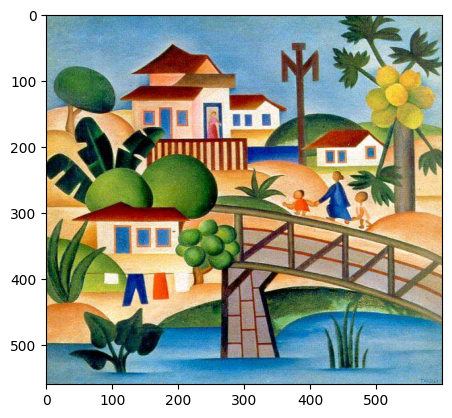

In [ ]:
plt.imshow(style_image)

In [ ]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

## Building the neural network

In [ ]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [ ]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    network = tf.keras.Model(inputs =  [vgg.input], outputs = outputs )

    return network

In [ ]:
style_extractor = vgg_layers(style_layers)

In [ ]:
style_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
style_outputs = style_extractor(style_image) # network의 predict 값

In [ ]:
len(style_outputs)

5

In [86]:
style_outputs[0].shape, style_outputs[1].shape , style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

KeyError: 0

In [84]:

# einsum 공식문서 :  https://www.tensorflow.org/api_docs/python/tf/einsum

# 이미지 손실을 측정할 때 사용된대.
def gram_matrix(layer_activation):
    #tensor contraction 차원 축소 :: filter의 수에 맞춰주는 건가??
    result = tf.linalg.einsum( 'bijc,bijd->bcd', layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    print(num_locations)
    return result / num_locations

In [85]:
gram_matrix(style_outputs[0])

KeyError: 0

In [87]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        # 상위 모델 호출 :: 여기선 tf.keras.models.Model 을 의미
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    # 객체가 호출되었을 때
    # inputs 는 이미지야.
    def call(self, inputs):
        # 이미지를 /255로 스케일 해서 돌려놓나봐.
        inputs = inputs * 255.0
        # -127.50 ~ 127.50 || vgg에 맞는 input 형태로 변환해.
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input) # 모델의 결과값, 총 5개가 될거야.
        style_outputs = outputs[:self.num_style_layers] # style 의 값부터 추가했으니
        content_outputs = outputs[self.num_style_layers:]

        # style 출력은 출력값의 특징 데이터만 뽑아 놓을 거야. gram 행렬로.
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name : value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name : value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content' : content_dict, 'style' : style_dict}

In [ ]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
results = extractor(content_image)

In [ ]:
for key , values in results.items():
    print(key, values.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [ ]:
# 이미지 손실 최소화(?)
style_targets = extractor(style_image)['style']
content_targets= extractor(content_image)['content']

In [ ]:
new_image = tf.Variable(content_image)

In [78]:
# 중요 :: 원하는 스타일의 양
content_weight =  1
style_weight = 1000

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate = 0.1)

## Training

In [ ]:
expected_output = np.array([10000,15000])
prediction = np.array([8000,15900])

In [ ]:
np.sum(abs(expected_output -prediction)) / 2

1450.0

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [72]:
mean_absolute_error(expected_output, prediction)

1450.0

In [74]:
mean_squared_error(expected_output, prediction)

2405000.0

In [77]:
((expected_output - prediction) ** 2).mean()

2405000.0

In [82]:
epochs = 500
print_every = 50
for epoch in range(epochs):
    with tf.GradientTape() as tape: # 역전파를 위해 연산값 기록 | 그래디언트를 계산할 때 사용하기 위해 단순 연산을 기록하는 거야. 이 안에 사용되는 모든 인수가 tape 변수에 저장돼.
        outputs = extractor(new_image) # 클래스 모델 : con_dict, style_dict 반환)

        content_outputs = outputs['content'] # content dict :: 각 layer의 output 값을 가지고 있어.
        style_outputs = outputs['style'] # style dict

        # 원본에서 이미지를 얼마나 많은 손실이 일어났는지 :: content_targets = 원본, content_output은 새로운 이미지
        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2 ) for name in content_outputs.keys()])
        # 이미지가 스타일을 얼마나 잃었는지
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2 ) for name in style_outputs.keys()])

        total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

    # tape에 저장된 인수 중 total_loss에 대한 new_image의 그래디언트 계산, 어떻게 해야 손실함수가 줄어들지 방향을 계산하는 듯
    gradient = tape.gradient(total_loss, new_image)
    #이 코드는 계산된 그래디언트를 사용하여 이미지를 업데이트합니다. 최적화기(optimizer)는 주어진 그래디언트를 사용하여 이미지를 업데이트하여 손실 함수를 최소화하는 방향으로 이동시킵니다.
    # 최적의 이동거리 느낌.
    optimizer.apply_gradients([(gradient, new_image)])
    # optimizer는 gradient를 기준으로 이동할 크기 및 방향을 추정해서 목표를 변화시켜.

    # 픽셀값이 0과 1 안에 있도록 적용.
    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if (epoch + 1) % print_every == 0:
        print(f'Epoch {epoch+1} | content loss : {content_loss} : style loss : {style_loss} | total loss {total_loss}')
        plt.imshow(tf.squeze(new_image, axis = 0))
        plt.show()

KeyboardInterrupt: 

## Visualizing the results

Text(0.5, 1.0, 'style_image')

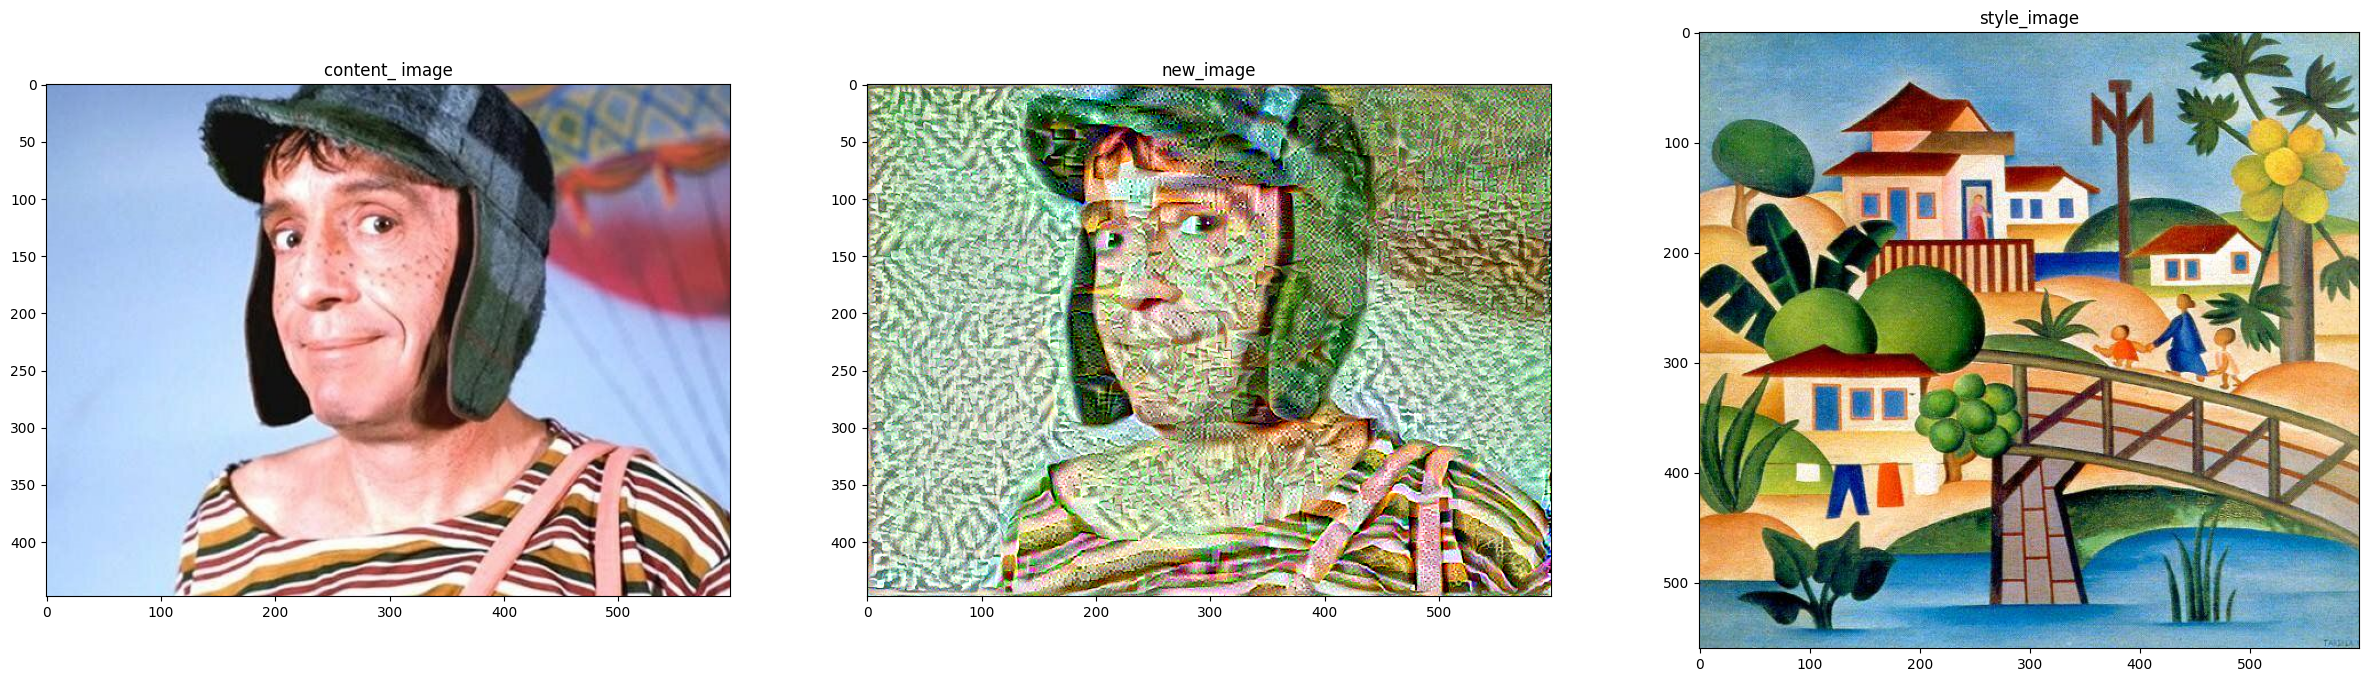

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (30,8))
ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title('content_ image')
ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('new_image')
ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('style_image')